In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#function for the outlier removal
def outlier_removal(without_outliers, **kwargs):
    #define input parameters
    outlier_columns = kwargs['outlier_columns'] 
    interquantile =   kwargs['interquantile']
    quantile_keep =   kwargs['quantile_keep']

    # first choose which method for outlier removal wants to be used. Use a for loop to iterate over the defined columns of the dataframe.
    if interquantile == True:
        outlier_range =   kwargs['outlier_range']
        for col in outlier_columns:
            # defined the interquantile range and then the upper and lower limit of the choosen column
            median = without_outliers[col].median()
            q_75 = without_outliers[col].quantile(q = 0.75)
            q_25 = without_outliers[col].quantile(q = 0.25)
            interquantile = q_75 - q_25                              
            upper_bound = median + (interquantile * outlier_range)
            lower_bound = median - (interquantile * outlier_range)

            # Create a boolean mask that is True for rows with a value less than or equal to the upper limit and higher or equal to the lower limit
            mask = (without_outliers[col] <= upper_bound) & (without_outliers[col] >= lower_bound)
            # Use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
    if interquantile == False: 
        
        for col in outlier_columns:
            #define the limit up to which the values are kept
            quantile_limit = without_outliers[col].quantile(q = 1)
            #define a boolean mask that is True for rows that are in the defined limit
            mask = without_outliers[col] < quantile_limit
            #use the mask to filter the dataframe
            without_outliers = without_outliers[mask]
    
        
    return without_outliers


# Input

Read.csv file of one TF or multiple TF. If the .csv file contains multiple TF a line in the data importation column has to be uncommented.

# Output

The file contains a data preprocessing step as well as a pipeline to apply linear/ridge regression. It can either give back the feature with the smallest mean absolute value as well as the corresponding coefficients, R^2-value and the degree of the polynomial feature expansion.
If save = True it additionally saves the plots in a .pdf format.

# 1. Data importation

In [3]:
TF = 'D8'
#adapt filepath if it's different
df = pd.read_csv ('../Features/TF1_'+TF+'.csv',index_col = 0)
ypet_intensity = df.copy()
#If file contains multiple TFs uncomment next line and add TF_name to analyze:
#ypet_intensity[ypet_intensity['TF_name'] == 'TF name of TF we are interested in']
Save = True #Will try to save it the conditions are suitable
ypet_intensity.head()

,patch,img,TF_name,blur_lapl,blur_ski,patch_size,mean_intensity,sum_intensity,median_intensity,standard_deviation,...,gabro_15,lbp_0,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,Circularity
0,patch_7,1,D - 8,False,False,2092,837.211759,1751447,836.0,62.479592,...,0.003472,0.246224,0.197885,0.086858,0.072508,0.051360,0.075529,0.087613,0.182024,0.891920
1,patch_8,1,D - 8,False,False,1662,818.845969,1360922,817.0,63.293191,...,0.137731,0.246363,0.196896,0.105723,0.064985,0.054316,0.088264,0.086324,0.157129,0.847813
2,patch_9,1,D - 8,False,False,1834,986.861505,1809904,923.0,196.877228,...,0.048387,0.207500,0.185000,0.099167,0.101667,0.083333,0.071667,0.085833,0.165833,0.768305
3,patch_10,1,D - 8,False,False,1390,822.346043,1143061,819.0,61.569710,...,0.062500,0.241458,0.187927,0.096811,0.069476,0.056948,0.071754,0.094533,0.181093,0.866470
4,patch_11,1,D - 8,False,False,1835,827.211444,1517933,825.0,63.382417,...,0.035377,0.235696,0.187874,0.096499,0.083689,0.061486,0.062340,0.084543,0.187874,0.904353


# 2. Task 1 - Regression model - best fit

## 2.1 Preprocessing

### Parameters to adapt for the data processing

In [4]:
#parameters to adapt for analyzation:
#outlier removal
outlier = True #If outliers in general should be removed True, if not False

if outlier == True: 
    outlier_columns = ['patch_size','sum_intensity'] #choose columns on which outliers should be removed: Be aware the more columns the more the whole data gets cut, not all the outliers in different columns rely on the same points: for all the columns: list(ypet_intensity_processed)[6:]
    quantile_keep = 1 # Quantile we want to keep. For removal: 0.85 we keep 85%
    interquantile = True #if outliers should be removed by defining a range with the interquantile: True; to remove outliers just when they're exceeding a certain quantile: False   
    outlier_range = 1.5 #if interquantile = True defined this value to define the range. Gets multiplicated with interquantile, else ignore


#Z-Normalization
normalization = False # True
columns_to_be_normalized =  ['patch_size','mean_intensity','median_intensity','sum_intensity'] #list(ypet_intensity_processed)[6:]  #if all columns should be normalized

#Log-Transformation
take_log = False #want to take the log of certain columns
columns_log = ['patch_size','mean_intensity','median_intensity','sum_intensity'] #needs pre-analyzation of columns if log is needed. With a histogram it can be seen if the distribution is skewed. 

# Blur removal
remove_blur_lapl = False # Laplacian filter
remove_blur_lapl_threshold = 10000 # Values above this threshold are removed

remove_blur_ski = True # perceptual blur
remove_blur_ski_threshold = 0.8 # Values above this threshold are removed

# Removal based on similarity
remove_similarity = False
similarity_threshold = 0.5 # Values below this threshold are removed

ypet_intensity_processed = ypet_intensity.copy()


### Outlier removal of predefined columns of the dataframe

In [5]:
#apply the function for outlier removal
if outlier == True:
    #group by the TF and just cut the outliers for one TF
    without_outliers = ypet_intensity_processed.groupby('TF_name',as_index=False).apply(outlier_removal, outlier_range=outlier_range, outlier_columns=outlier_columns, interquantile = interquantile, quantile_keep=quantile_keep).reset_index()
    #change index so dataframe is as before
    without_outliers = without_outliers.drop(['level_0'],axis=1)
    without_outliers = without_outliers.set_index('level_1')
    without_outliers.index.name = None
    #save it under a new dataframe
    ypet_intensity_processed = without_outliers.copy()

### Log-Transformation on specified columns in the dataframe

In [6]:
#take logs of predefined columns that are skewed:
if take_log == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    log_rows = TF_grouped[columns_log].transform(lambda x: np.log(x))
    ypet_intensity_processed[columns_log] = log_rows 

### Z-score normalization on specified columns in the dataframe

In [7]:
# Normalization of columns of the dataframe
if normalization == True:
    TF_grouped = ypet_intensity_processed.groupby('TF_name')
    Normalized_columns = TF_grouped[columns_to_be_normalized].transform(lambda x: (x - x.mean()) / x.std()) #removed rows_to_be to have all col normalized

    # Replace normalized
    ypet_intensity_processed[columns_to_be_normalized] = Normalized_columns                         


### Similarity removal

In [8]:
if remove_similarity == True:
        remove_boolean = ypet_intensity_processed.similarity > similarity_threshold
        ypet_intensity_processed = ypet_intensity_processed[remove_boolean]

### Blurr removal

In [9]:
if remove_blur_lapl == True:
        remove_boolean = ypet_intensity_processed.blur_lapl < remove_blur_lapl_threshold
        ypet_intensity_processed = ypet_intensity_processed[remove_boolean]
        
if remove_blur_ski == True:
        remove_boolean = ypet_intensity_processed.blur_ski < remove_blur_ski_threshold
        ypet_intensity_processed = ypet_intensity_processed[remove_boolean]

## 2.2 Data visualization

Show similarity of the result:

In [10]:
Save = True

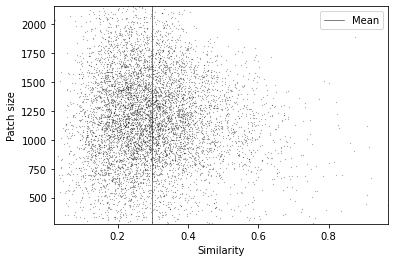

In [11]:
sns.regplot(y="patch_size", x="similarity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':0.1}, color = 'black', fit_reg=False)
plt.xlabel("Similarity"); plt.ylabel("Patch size")
plt.axvline(np.mean(ypet_intensity_processed['similarity']),color = 'black',linewidth = 0.5,label = "Mean")
plt.xlim(ypet_intensity_processed.similarity.min(),ypet_intensity_processed.similarity.max())
plt.ylim(ypet_intensity_processed.patch_size.min(),ypet_intensity_processed.patch_size.max())
plt.legend()
if Save:
    plt.savefig("../Images/task1/densities_similarity_"+TF+".pdf")

Show a scatterplot of two variables used in the regression models

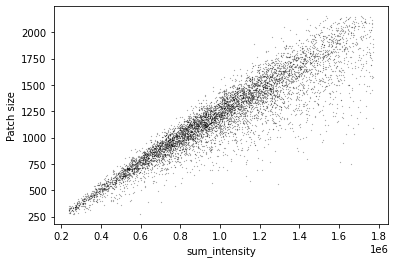

In [12]:
#To adapt for the parameter wished to desplay
sns.regplot(y="patch_size", x="sum_intensity", data=ypet_intensity_processed,marker = '.',scatter_kws={'s':0.1}, color = 'black', fit_reg=False)
plt.xlabel("sum_intensity")
plt.ylabel("Patch size")
if Save:
    plt.savefig("../Images/task1/sum_intensity_"+TF+".pdf")

## 2.3 Select best model

### Parameters to adapt

In [23]:
maxdegree = 10                          #To define is the maximum degree of the polynomial that should be tried (maxdegree of 5 takes degree up to 4 into account)
alphas = [1e-4,1e-3, 1e-2, 1e-1, 1]     #Alpha grid for ridge regression
K = 10                                  #Number of fold for the cross validation
x_features = ['mean_intensity','median_intensity'] #add features for x for which the best model have to be find
decide_y_feature = 'patch_size' #decide y-feature
mode_error = mean_absolute_error #mean_absolute_error # mean_squared_error # mean_absolute_error

if mode_error == mean_squared_error:
    error_cv = 'neg_mean_squared_error'
else:
    error_cv = 'neg_mean_absolute_error'

In [24]:
x_features = ['mean_intensity','sum_intensity','similarity','median_intensity'] #define a list with all the columns that could be interesting for task 1
decide_x_features = np.array([1])      #set the list of indexes for the X values used for regression from list defined in x_features
decide_y_feature = 'patch_size'        #also other features could be taken into account
mode_error = mean_absolute_error #mean_absolute_error # mean_squared_error # mean_absolute_error

### choose best model

In [25]:
#define a test and a training set
df_train, df_test = train_test_split(ypet_intensity_processed, train_size = 0.8, test_size = 0.2, random_state = 10)

In [26]:
#Define features used with the right format, following x_features and decide_x_features
features_used = [x_features[i] for i in decide_x_features]
# Split in train and test set -- CAREFUL: defines other train/test set than above, can lead to slightly different results
df_train, df_test = train_test_split(ypet_intensity_processed, train_size = 0.8, test_size = 0.2, random_state = 10)

#define the x and the y for the test and train sets
df_train_x = df_train[features_used]
df_test_x = df_test[features_used]
df_train_y = df_train[[decide_y_feature]]
df_test_y = df_test[[decide_y_feature]]

In [27]:
#model to select
cross_validation_ridge_error = np.zeros(maxdegree)
cross_validation_lm_error = np.zeros(maxdegree)

#see which degree fits data the best for linear regression
for d in range(1, maxdegree+1):    #it will create 1,2...maxdregree range vector like this
    #polynomial feature expansion of x_train
    x_poly_train = PolynomialFeatures(degree=d).fit_transform(df_train_x)
    #apply linear regression model and cross-validation for alpha-ridge regression
    lr = LinearRegression()
    rr = RidgeCV(alphas=alphas)
    #apply cross validation
    cve = cross_validate(lr,x_poly_train,df_train_y,scoring= error_cv, cv=K, return_train_score=True)
    crr = cross_validate(rr,x_poly_train,df_train_y,scoring=error_cv, cv=K, return_train_score=True)
    #make array for cross validation with linear model and for ridge regression
    cross_validation_lm_error[d-1] = np.mean(np.absolute(cve['test_score']))
    cross_validation_ridge_error[d-1] = np.mean(np.absolute(crr['test_score']))

In [28]:
index_min_lm = np.argmin(cross_validation_lm_error)
index_min_ridge = np.argmin(cross_validation_ridge_error)

poly_lm_test = PolynomialFeatures(degree=index_min_lm+1)
x_poly_test_lm = poly_lm_test.fit_transform(df_test_x)
poly_lm_train = PolynomialFeatures(degree=index_min_lm+1)
x_poly_train_lm = poly_lm_train.fit_transform(df_train_x)

x_poly_train_df_lm = pd.DataFrame(x_poly_train_lm)
x_poly_test_df_lm = pd.DataFrame(x_poly_test_lm)

poly_ridge_test = PolynomialFeatures(degree=index_min_ridge+1)
x_poly_test_ridge = poly_ridge_test.fit_transform(df_test_x)
poly_ridge_train = PolynomialFeatures(degree=index_min_ridge+1)
x_poly_train_ridge = poly_ridge_train.fit_transform(df_train_x)

x_poly_train_df_ridge = pd.DataFrame(x_poly_train_ridge)
x_poly_test_df_ridge = pd.DataFrame(x_poly_test_ridge)

#make linear model
model_lm = LinearRegression().fit(x_poly_train_df_lm, df_train_y)
model_ridge = RidgeCV(alphas=[1e-4,1e-3, 1e-2, 1e-1, 1]).fit(x_poly_train_df_ridge, df_train_y)

#train error
y_train_pred_lm = model_lm.predict(x_poly_train_lm)
mse_train_lm = mode_error(df_train_y,y_train_pred_lm)
y_train_pred_ridge = model_ridge.predict(x_poly_train_ridge)
mse_train_ridge = mode_error(df_train_y,y_train_pred_ridge) 

#test error
y_test_pred_lm = model_lm.predict(x_poly_test_df_lm)
mae_test_lm = mode_error(df_test_y,y_test_pred_lm)
y_test_pred_ridge = model_ridge.predict(x_poly_test_df_ridge)
mae_test_ridge = mode_error(df_test_y,y_test_pred_ridge)

### Parameters for the best model 

In [29]:
if mae_test_ridge >= mae_test_lm:
    feature_names = poly_lm_test.get_feature_names_out(input_features=features_used)
    print('take linear regression')
    print('features: ',feature_names)
    print('coefficients: ',model_lm.coef_) 
    print('intercept: ',model_lm.intercept_)
    print('R^2-score: ', r2_score(df_test_y,y_test_pred_lm))
    print('Mean absolute test error:', round(mae_test_lm,3))

else:
    feature_names = poly_ridge_test.get_feature_names_out(input_features=features_used)
    print('take ridge regression')
    print('features: ',feature_names)
    print('coefficients: ',model_ridge.coef_)
    print('intercept: ',model_ridge.intercept_)
    print('alpha: ',model_ridge.alpha_)
    print('R^2-score: ', r2_score(df_test_y,y_test_pred_ridge))
    print('Mean absolute test error:', round(mae_test_ridge,3))

take linear regression
features:  ['1' 'sum_intensity' 'sum_intensity^2' 'sum_intensity^3']
coefficients:  [[ 0.00000000e+00  1.27601749e-03  1.14477425e-11 -7.26415456e-17]]
intercept:  [-1.29615418]
R^2-score:  0.8557663706945386
Mean absolute test error: 97.734


### Visualize the best model

The visualization part is just possible, when X contains just one feature.

In [30]:
Save = True

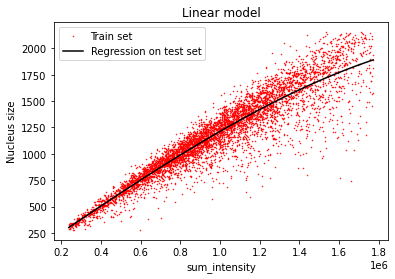

In [31]:
#show predicted points with linear model
df_plot_sort = pd.DataFrame(df_test_x)
df_plot_sort['reg'] =  y_test_pred_lm[:,0]
df_plot_sort.sort_values(features_used[0],inplace = True)

#show predicted points with linear model

if (len(features_used)!=1):
    warnings.warn("WARNING features_used should be of len 1 for this plot")
else:
    plt.figure()
    plt.plot(df_train_x,df_train_y, 'r.',markersize = 1,label = "Train set")
    plt.plot(df_plot_sort[features_used[0]],df_plot_sort['reg'],color = 'black',label = "Regression on test set")
    plt.ylabel("Nucleus size")
    plt.xlabel(features_used[0])    #WARNING features_used should be of len 1 for this plot
    plt.title("Linear model")
    plt.legend()
    #plt.yscale("log")
    #plt.xscale("log")
    if Save:
        plt.savefig("../Images/task1/linear_model_"+features_used[0]+"_"+TF+".pdf") 
    plt.show()

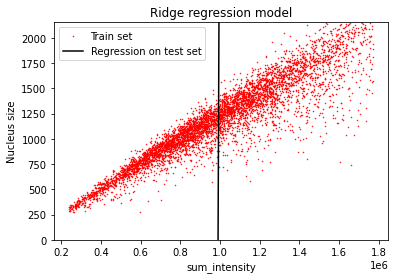

In [22]:
#show predicted points with ridge model
df_plot_sort_ridge = pd.DataFrame(df_test_x)
df_plot_sort_ridge['reg'] =  y_test_pred_ridge[:,0]
df_plot_sort_ridge.sort_values(features_used[0],inplace = True)

if (len(features_used)!=1):
    warnings.warn("WARNING features_used should be of len 1 for this plot")
else:
    plt.figure()
    plt.plot(df_train_x,df_train_y, 'r.',markersize = 1,label = "Train set")
    plt.plot(df_plot_sort_ridge[features_used[0]],df_plot_sort_ridge['reg'],color = 'black',label = "Regression on test set")
    plt.ylabel("Nucleus size")
    plt.ylim(0,df_train_y.patch_size.max())
    plt.xlabel(features_used[0])    #WARNING features_used should be of len 1 for this plot
    plt.title("Ridge regression model")
    plt.legend()
    #plt.yscale("log")
    #plt.xscale("log")
    if Save:
        plt.savefig("../Images/task1/ridge_model_"+features_used[0]+"_"+TF+".pdf")
    plt.show()
#plt.savefig('ridge_original', dpi = 300)